# Set overall settings

In [1]:
# Import packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pickle
import math as math
from matplotlib import gridspec
import os
import seaborn as sns
%matplotlib inline
import pandas as pd
from scipy import stats

In [2]:
#Set figure style

%matplotlib inline
plt.style.use("seaborn-white")
# plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['legend.fontsize'] = 6
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = 'Arial'
colors = [i['color'] for i in plt.rcParams['axes.prop_cycle']]
plt.rcParams["figure.dpi"] = 200
plt.rcParams['grid.color'] = 'white'

In [3]:
# Set color scheme to match figure
fig3 = ["#5391B3","#336667","#939598", "#B492B1", "#BD9F8D","#9BB9CF", "#75AF7E", "#AADBDC"]
sns.set_palette(fig3)
# sns.palplot(sns.color_palette())

In [4]:
# Load model functions
def signal_periodic(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p/2)*slope_on < 1:
        maxs = (p/2)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        it = math.floor(t/signal_number)
        if t>=it*p and t < it*p+p/2:
            if t >= it*p and t < it*p+(1/slope_on):
                return ((t-it*p)*slope_on)
            else:
                return 1
        else:
            return 0
def signal_single(signal_number,t,slope_on,slope_off):
    p = signal_number
    if (p)*slope_on < 1:
        maxs = (p)*slope_on
    else:
        maxs = 1
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        if t < p:
            if t <= p and t < (1/slope_on):
                return ((t)*slope_on)
            else:
                return 1
        else:
            return 0
            
def DE_periodic(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_periodic(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def DE_single(y,t,signal_number,slope_on,slope_off):
    GFP, Fus3, ppFus3, Ste12, Ste12Digs, Far1, pFar1 = y

    s=signal_single(signal_number,t,slope_on,slope_off)

    # GFP
    dGFPdt = ksynGFP+(ka4*Ste12**hc)/(KGFP+Ste12**hc)-kdegGFP*GFP
    # Fus3
    dFus3dt = ksynF3+(kfb1*Ste12**hc)/(KFus3+Ste12**hc)-kp1*s*Fus3+kp2*ppFus3-kdegF3*Fus3
    # ppFus3
    dppFus3dt = kp1*s*Fus3-kp2*ppFus3
    # Ste12
    dSte12dt = ksynS12+(kfb2*Ste12**hc)/(KSte12+Ste12**hc)-kdegS12*Ste12*(1+(kff*pFar1)/(km1+pFar1))-ka1*Ste12*(DigsT-Ste12Digs)+(ka2*ppFus3+ka3)*Ste12Digs
    # Ste12Digs
    dSte12Digsdt = ka1*Ste12*(DigsT-Ste12Digs)-(ka2*ppFus3+ka3+kdegS12D)*Ste12Digs
    # Far1
    dFar1dt = ksynF1+(ka5*Ste12**hc)/(KFar1+Ste12**hc)+kp3*pFar1-kp4*ppFus3*Far1-kdegF1*Far1
    # pFar1
    dpFar1dt = kp4*ppFus3*Far1-kp3*pFar1-kdegPF1*pFar1

    return [dGFPdt, dFus3dt, dppFus3dt, dSte12dt, dSte12Digsdt, dFar1dt, dpFar1dt]
def simulate_periodic_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff1,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_periodic, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes
def simulate_singlepulse_experiment(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff1,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_parameters
    # parameters to be kept constant
    kdegGFP = 10**-1
    hc = 1
    #solve odes:
    odes = odeint(DE_single, SS, time, args=(signal_val,slope_on,slope_off,))
    # return array of individual cell counts:
    return odes

# Figure 2
## Figure 2F - Western quantification

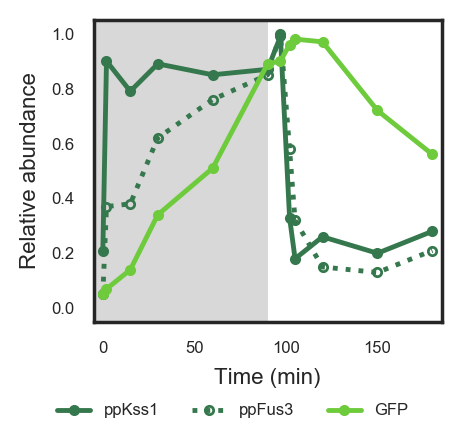

In [5]:
# plot
ppKss1 = [0.21,0.90,0.79,0.89,0.85,0.87,0.99,0.33,0.18,0.26,0.20,0.28]
ppFus3 = [0.05,0.37,0.38,0.62,0.76,0.85,1.00,0.58,0.32,0.15,0.13,0.21]
GFP = [0.05,0.07,0.14,0.34,0.51,0.89,0.90,0.96,0.98,0.97,0.72,0.56]
time = [0,2,15,30,60,90,97,102,105,120,150,180]
fig = plt.figure(figsize=(2.24409,2))
plt.plot(time,ppKss1,color=(54/255,120/255,77/255),marker='o',markersize=4)
plt.plot(time,ppFus3,color=(54/255,120/255,77/255),marker='o',markersize=3,linestyle=':',markerfacecolor='None',markeredgewidth=1)
plt.plot(time,GFP,color='xkcd:apple',marker='o',markersize=4)
plt.xlabel('Time (min)')
plt.ylabel('Relative abundance')
plt.fill_between([-5,90], -5, 1.2, facecolor='gray', alpha=0.3)
plt.xlim([-5,185])
plt.ylim([-0.05,1.05])
lgd = plt.legend(['ppKss1','ppFus3','GFP'],loc='upper center', bbox_to_anchor=(0.4, -0.22),ncol=3)
plt.savefig('2F.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

## Figure 2D

In [7]:
# Single pulse data
filename = '/Users/AmyAllen/Documents/Mating-Model/Data/Experimental Data/experimental.pickled'
data_to_score_against = filename
with open(filename, 'rb') as f:
    experimental = pickle.load(f)
times_50constant, data_50constant, times_50pulse, data_50pulse, times_50periodic, data_50periodic, times_10periodic, data_10periodic = experimental

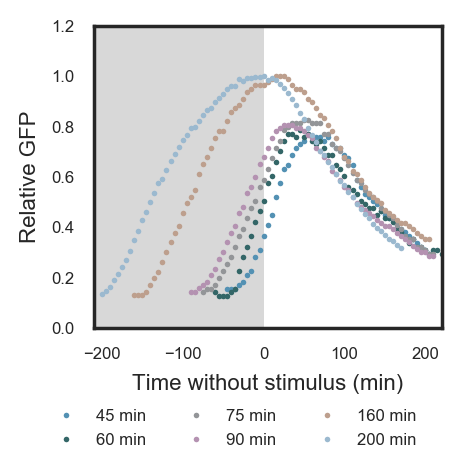

In [9]:
# plot
fig = plt.figure(figsize=(2.24409,2))
dur = [45,60,75,90,160,200]
for i in [0,1,2,3,4,5]:
    plt.plot(times_50pulse[i]-dur[i],data_50pulse[i],marker='o',markersize=2,linestyle='None')
plt.xlabel('Time without stimulus (min)')
plt.ylabel('Relative GFP')
plt.fill_between([-210,0], -5, 1.5, facecolor='gray', alpha=0.3)
plt.xlim([-210,220])
plt.ylim([0,1.2])
lgd = plt.legend(['45 min','60 min','75 min', '90 min', '160 min', '200 min'],loc='upper center', bbox_to_anchor=(0.4, -0.22),ncol=3)
plt.savefig('2D.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

## Figure 2C

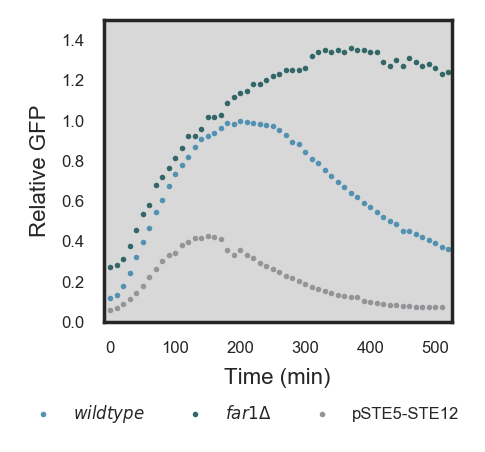

In [10]:
# plot
fig = plt.figure(figsize=(2.24409,2))
plt.plot(times_50constant[0],data_50constant[0],marker='o',markersize=2,linestyle='None')
plt.plot(times_50constant[2],data_50constant[2],marker='o',markersize=2,linestyle='None')
plt.plot(times_50constant[1],data_50constant[1],marker='o',markersize=2,linestyle='None')
plt.xlabel('Time (min)')
plt.ylabel('Relative GFP')
plt.fill_between([-10,660], -5, 1.5, facecolor='gray', alpha=0.3)
plt.xlim([-10,525])
plt.ylim([0,1.5])
lgd = plt.legend(['$wildtype$','$far1\Delta$','pSTE5-STE12'],loc='upper center', bbox_to_anchor=(0.4, -0.22),ncol=3)
plt.savefig('2C.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

# Figure 3
## Figure 3B - Memory vs. Pulse Length

In [11]:
# Calculate memory
maxindex = []
memory = []
pulse = [45,60,75,90,160,200]
for i,n in enumerate(data_50pulse[0:6]):
    n = n.tolist()
    maxindex.append(n.index(max(n))*5)
    memory.append(n.index(max(n))*5-pulse[i])

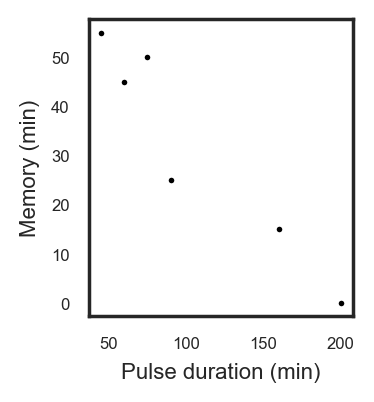

In [12]:
# Plot
fig = plt.figure(figsize=(1.7,1.9685))
plt.plot(pulse,memory,'ko',markersize=2)
plt.xlabel('Pulse duration (min)')
plt.ylabel('Memory (min)')
plt.savefig('3B.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

## Figure 3C

In [13]:
# Function to load data
def load_data(dir_path_data, score_cutoff):
    #MSE threshold score at which to not include 
    val_to_keep_end_score = score_cutoff
    
    #load new data:
    arr_best_scores = []
    arr_best_inds = []
    arr_end_scores = []
    dir_to_check = dir_path_data #'/home/iammoresentient/phd_lab/170307_data_sin_y1'
    files = os.listdir(dir_to_check)
    for i in range(0,len(files)):
        filename = dir_to_check + '/' + files[i]
        if os.path.isfile(filename):
            if os.path.getsize(filename) > 0: 
                if '.pickled' in files[i]:
                    #print(filename)
                    arr_to_unpickle = pickle.load(open(filename,'rb'))
                    arr_best_score, arr_best_ind = arr_to_unpickle
                    temp_end_score = arr_best_score[-1]
                    if temp_end_score < val_to_keep_end_score:
                        arr_end_scores.append(temp_end_score)
                        arr_best_scores.append(arr_best_score)
                        arr_best_inds.append(arr_best_ind)


    print('Loaded ' + str(len(arr_best_scores)) + ' files (out of ' + str(len(files)) + ') with cutoff score of ' + str(score_cutoff))

    #convert to numpy
    arr_best_scores = np.asarray(arr_best_scores)
    arr_best_inds = np.asarray(arr_best_inds)
    arr_end_scores = np.asarray(arr_end_scores)

    return arr_best_scores, arr_end_scores, arr_best_inds

In [15]:
# Load data
directory = '/Users/AmyAllen/Documents/Mating-Model/Data/Linear Model/180321_LinearPeriodicV2_100g500i10m50c/'
arr_best_scores, arr_end_scores, arr_best_inds=load_data(directory,1.055)
arrT_best_inds = arr_best_inds.transpose()

Loaded 25 files (out of 411) with cutoff score of 1.055


In [16]:
def signal(signal_number,t,slope_on,slope_off):
    p = signal_number
        
    if signal_number == 0:
        return 0
    elif signal_number == 1:
        if t < 1/slope_on:
            return t*slope_on
        else:
            return 1
    else :
        if t < p:
            return 1
        else:
            return 0
def DE(y,t,signal_number,slope_on,slope_off):
    X1,X2,X3,X4 = y
        
    s=signal(signal_number,t,slope_on,slope_off)
        
    # X1
    dX1dt = s-d1*X1
    # X2
    dX2dt = k1*X1-d2*X2
    # X3
    dX3dt = k2*X2-d3*X3
    # X4
    dX4dt = k3*X3-d4*X4
        
    return [dX1dt,dX2dt,dX3dt,dX4dt]
            
def simulate_single_experiment1(arr_parameters, time, signal_val,SS):
    # parameters to be learned
    k1, k2, k3, d1, d2, d3, d4 = arr_parameters
    #solve odes:
    odes = odeint(DE, SS, time, args=(signal_val,1,1,))
    # return array of individual cell counts:
    return odes

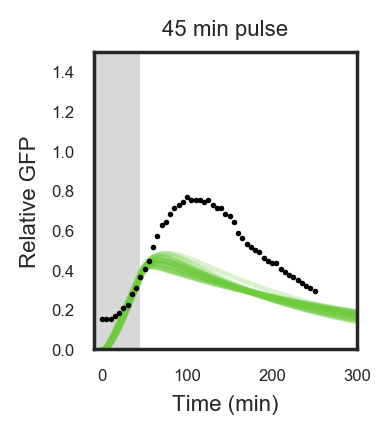

In [17]:
# plot
gen = 100
IC = [0,0,0,0]
t  = np.linspace(0,40000,100001)
t1 = np.linspace(0,300,3000)
fig = plt.figure(figsize=(1.7,1.9685))
for j in range(len(arr_best_inds[:,gen])):
    for i in range(1):
        expX = 0
        k1, k2, k3, d1, d2, d3, d4 = arr_best_inds[j][gen]
        curr_params = [k1, k2, k3, d1, d2, d3, d4]
        odes = odeint(DE, IC, t, args=(0,1,1,))
        SS=odes[100000,:]
        expX = simulate_single_experiment1(curr_params, t1, 45,SS)
        plt.plot(t1,expX[:,3],color='xkcd:apple',alpha=0.25)
plt.plot(times_50pulse[0],data_50pulse[0],'ko',markersize = 2)
plt.title('45 min pulse')
plt.xlabel('Time (min)')
plt.ylabel('Relative GFP')
plt.ylim([0,1.5])
plt.xlim([-10,300])
plt.fill_between([-10,45], -0, 1.5, facecolor='gray', alpha=0.3)
plt.savefig('3C.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

## Figure 3D

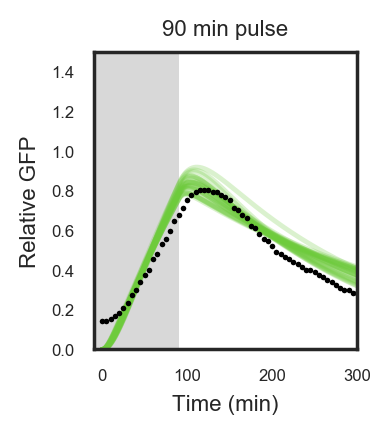

In [18]:
# plot
gen = 100
IC = [0,0,0,0]
t  = np.linspace(0,40000,100001)
t1 = np.linspace(0,300,3000)
fig = plt.figure(figsize=(1.7,1.9685))
for j in range(len(arr_best_inds[:,gen])):
    for i in range(1):
        expX = 0
        k1, k2, k3, d1, d2, d3, d4 = arr_best_inds[j][gen]
        curr_params = [k1, k2, k3, d1, d2, d3, d4]
        odes = odeint(DE, IC, t, args=(0,1,1,))
        SS=odes[100000,:]
        expX = simulate_single_experiment1(curr_params, t1, 90,SS)
        plt.plot(t1,expX[:,3],color='xkcd:apple',alpha=0.25)
plt.plot(times_50pulse[3],data_50pulse[3],'ko',markersize = 2)
plt.title('90 min pulse')
plt.xlabel('Time (min)')
plt.ylabel('Relative GFP')
plt.ylim([0,1.5])
plt.xlim([-10,300])
plt.fill_between([-10,90], -0, 1.5, facecolor='gray', alpha=0.3)
plt.savefig('3D.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

## Figure 3E

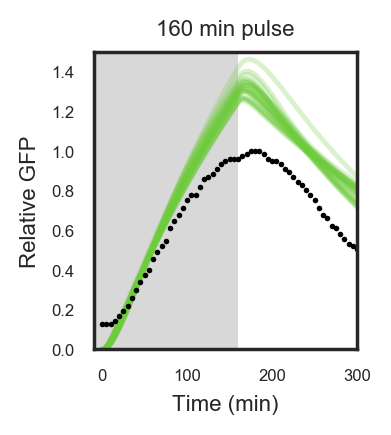

In [19]:
# plot
gen = 100
IC = [0,0,0,0]
t  = np.linspace(0,40000,100001)
t1 = np.linspace(0,300,3000)
fig = plt.figure(figsize=(1.7,1.9685))
for j in range(len(arr_best_inds[:,gen])):
    for i in range(1):
        expX = 0
        k1, k2, k3, d1, d2, d3, d4 = arr_best_inds[j][gen]
        curr_params = [k1, k2, k3, d1, d2, d3, d4]
        odes = odeint(DE, IC, t, args=(0,1,1,))
        SS=odes[100000,:]
        expX = simulate_single_experiment1(curr_params, t1, 160,SS)
        plt.plot(t1,expX[:,3],color='xkcd:apple',alpha=0.25)
plt.plot(times_50pulse[4],data_50pulse[4],'ko',markersize = 2)
plt.title('160 min pulse')
plt.xlabel('Time (min)')
plt.ylabel('Relative GFP')
plt.ylim([0,1.5])
plt.xlim([-10,300])
plt.fill_between([-10,160], -0, 1.5, facecolor='gray', alpha=0.3)
plt.savefig('3E.png',dpi=600,bbox_extra_artists=(lgd,), bbox_inches='tight')

# Figure S1

/Users/AmyAllen/anaconda/envs/python3/lib/python3.6/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


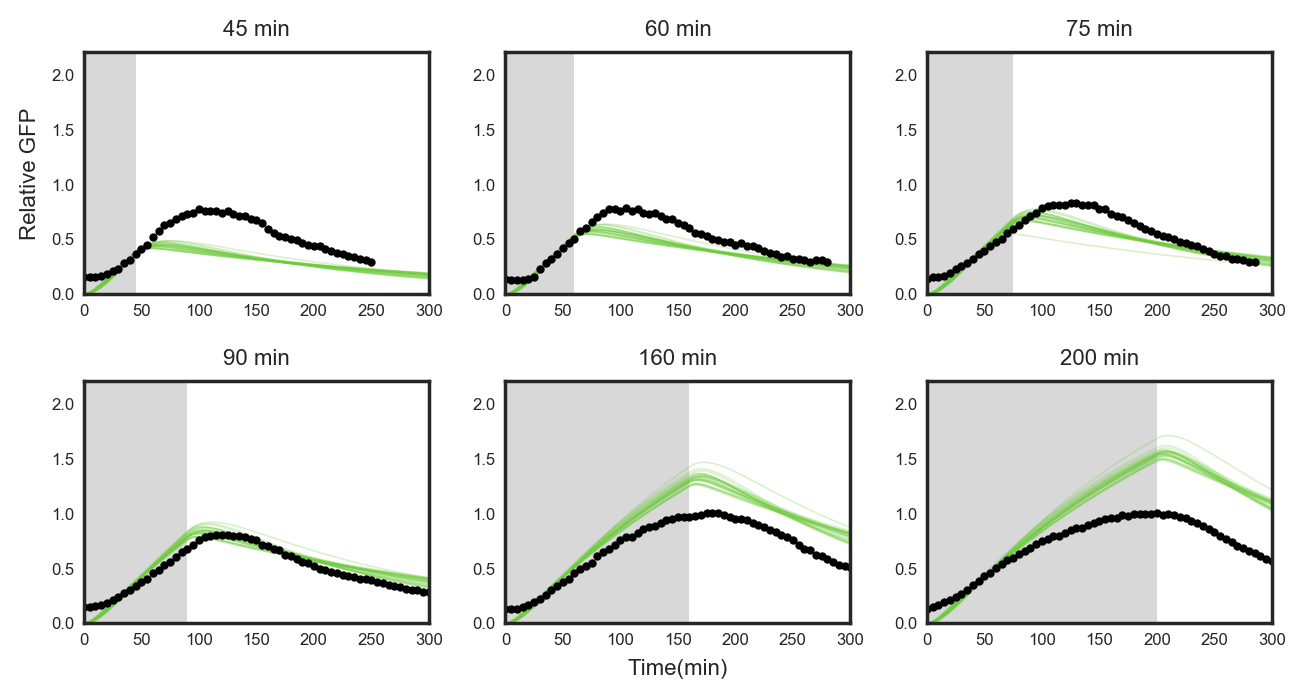

In [41]:
# Plot figure
fig = plt.figure(figsize=(6.85039, 3.75))
gs = gridspec.GridSpec(2,3)
A = fig.add_subplot(gs[0,0])
B = fig.add_subplot(gs[0,1])
C = fig.add_subplot(gs[0,2])
D = fig.add_subplot(gs[1,0])
E = fig.add_subplot(gs[1,1])
F = fig.add_subplot(gs[1,2])
ax = fig.add_subplot(gs[:,:])

# remove figure markings
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.grid('off')

#DEFINE STEADY STATE - WT

gen = 100
IC = [0,0,0,0]
t  = np.linspace(0,40000,100001)
t1 = np.linspace(0,300,3000)

for j in range(len(arr_best_inds[:,gen])):
    k1, k2, k3, d1, d2, d3, d4 = arr_best_inds[j][gen]
    curr_params = [k1, k2, k3, d1, d2, d3, d4]
    odes = odeint(DE, IC, t, args=(0,1,1,))
    SS=odes[100000,:]
    for i in [45,60,75,90,160,200]:
        expX = 0
        expX = simulate_single_experiment1(curr_params, t1, i,SS)
        if i == 45:
            A.plot(t1, expX[:,3],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 60: 
            B.plot(t1, expX[:,3],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 75: 
            C.plot(t1, expX[:,3],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 90:
            D.plot(t1, expX[:,3],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 160:
            E.plot(t1, expX[:,3],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 200:
            F.plot(t1, expX[:,3],color='xkcd:apple',alpha=0.25,linewidth=0.6)

scorefxn_time = times_50pulse
scorefxn_data = data_50pulse
A.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=2)
A.axis([0, 300, 0, 2.2])
B.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=2)
B.axis([0, 300, 0, 2.2])
C.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=2)
C.axis([0, 300, 0, 2.2])
D.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=2)
D.axis([0, 300, 0, 2.2])
E.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=2)
E.axis([0, 300, 0, 2.2])
F.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=2)
F.axis([0, 300, 0, 2.2])


for i in range(1):
    A.fill_between([i*90,i*90+45], 0, 2.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    B.fill_between([i*120,i*120+60], 0, 2.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    C.fill_between([i*150,i*150+75], 0, 2.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    D.fill_between([i*180,i*180+90], 0, 2.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    E.fill_between([i*320,i*320+160], 0, 2.2, facecolor='gray', alpha=0.3)

for i in range(1):
    F.fill_between([i*400,i*400+200], 0, 2.2, facecolor='gray', alpha=0.3)
    
A.set_ylabel('Relative GFP')
ax.set_xlabel('Time(min)')

A.set_title('45 min')
B.set_title('60 min')
C.set_title('75 min')
D.set_title('90 min')
E.set_title('160 min')
F.set_title('200 min')
gs.tight_layout(fig)

plt.savefig('Figure S1.pdf',dpi=600)

# Figure 4
## Figure 4C - Error vs. Generation

In [102]:
# Load data (top 5%)

## All Data
directory = '/Users/AmyAllen/Documents/Mating-Model/Data/Full Model/Scaled Data/190528_AllData_100g500i10m50c/'
all_best_scores_P, all_end_scores_P, all_best_inds_P=load_data(directory,1.48)
allT_best_inds_P = all_best_inds_P.transpose()

## All Data
directory = '/Users/AmyAllen/Documents/Mating-Model/Data/Full Model/Scaled Data/190528_AllDataNoPeriodic_100g500i10m50c/'
noPer_best_scores_P, noPer_end_scores_P, noPer_best_inds_P=load_data(directory,0.875)
noPerT_best_inds_P = noPer_best_inds_P.transpose()

## All Data
directory = '/Users/AmyAllen/Documents/Mating-Model/Data/Full Model/Scaled Data/190528_AllDataNoPulse_100g500i10m50c/'
noPul_best_scores_P, noPul_end_scores_P, noPul_best_inds_P=load_data(directory,1.01)
noPulT_best_inds_P = noPul_best_inds_P.transpose()

## All Data
directory = '/Users/AmyAllen/Documents/Mating-Model/Data/Full Model/Scaled Data/190528_Constants_100g500i10m50c/'
cons_best_scores_P, cons_end_scores_P, cons_best_inds_P=load_data(directory,0.2895)
consT_best_inds_P = cons_best_inds_P.transpose()

## All Data
directory = '/Users/AmyAllen/Documents/Mating-Model/Data/Full Model/Scaled Data/190528_WTConstant_100g500i10m50c/'
wt_best_scores_P, wt_end_scores_P, wt_best_inds_P=load_data(directory,0.233976166516205)
wtT_best_inds_P = wt_best_inds_P.transpose()


Loaded 26 files (out of 504) with cutoff score of 1.48
Loaded 24 files (out of 462) with cutoff score of 0.875
Loaded 22 files (out of 433) with cutoff score of 1.01
Loaded 22 files (out of 433) with cutoff score of 0.2895
Loaded 13 files (out of 256) with cutoff score of 0.233976166516205


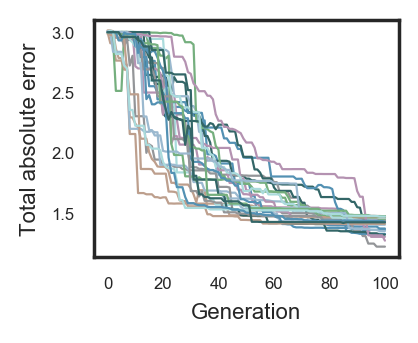

In [104]:
# plot

# SPECIFY DATA SET
arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 

gen = 100
fig = plt.figure(figsize=(1.9685,1.5748))
for i in range(len(arr_best_scores_P)):
    plt.plot(np.linspace(0,gen,gen+1),arr_best_scores_P[i][0:gen+1],linewidth=0.8)
plt.xlabel('Generation')
plt.ylabel('Total absolute error')
plt.savefig('4C.png',dpi=600,bbox_inches='tight')

# Figure 5

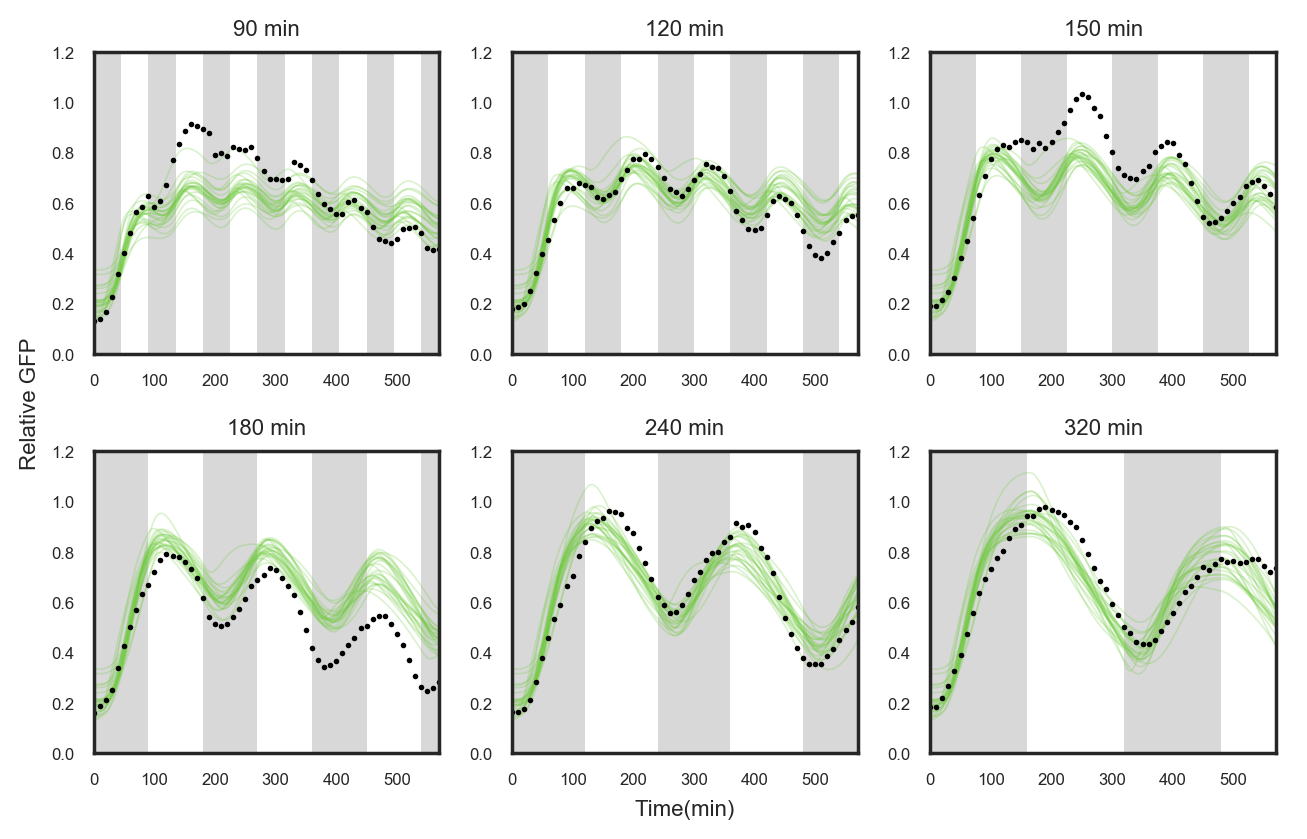

In [105]:
# Plot figure

# SPECIFY DATA SET
arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 

fig = plt.figure(figsize=(6.85039, 4.5))
gs = gridspec.GridSpec(2,3)
A = fig.add_subplot(gs[0,0])
B = fig.add_subplot(gs[0,1])
C = fig.add_subplot(gs[0,2])
D = fig.add_subplot(gs[1,0])
E = fig.add_subplot(gs[1,1])
F = fig.add_subplot(gs[1,2])
ax = fig.add_subplot(gs[:,:])

# remove figure markings
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.grid('off')

#DEFINE STEADY STATE - WT
hc=2
kdegGFP=10**-1
slope_off = 0
time = np.linspace(0,570,571)
SS=[]
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    for i in [90,120,150,180,240,320]:
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 90:
            A.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 120: 
            B.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 150: 
            C.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 180:
            D.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 240:
            E.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 320: 
            F.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)

scorefxn_time = times_50periodic
scorefxn_data = data_50periodic
A.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=2)
A.axis([0, 570, 0, 1.2])
B.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=2)
B.axis([0, 570, 0, 1.2])
C.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=2)
C.axis([0, 570, 0, 1.2])
D.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=2)
D.axis([0, 570, 0, 1.2])
E.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=2)
E.axis([0, 570, 0, 1.2])
F.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=2)
F.axis([0, 570, 0, 1.2])

for i in range(7):
    A.fill_between([i*90,i*90+45], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(5):
    B.fill_between([i*120,i*120+60], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(4):
    C.fill_between([i*150,i*150+75], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(4):
    D.fill_between([i*180,i*180+90], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(3):
    E.fill_between([i*240,i*240+120], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(2):
    F.fill_between([i*320,i*320+160], 0, 1.2, facecolor='gray', alpha=0.3)
    
ax.set_ylabel('Relative GFP')
ax.set_xlabel('Time(min)')

A.set_title('90 min')
B.set_title('120 min')
C.set_title('150 min')
D.set_title('180 min')
E.set_title('240 min')
F.set_title('320 min')

gs.tight_layout(fig)

plt.savefig('Figure 5.pdf',dpi=600)

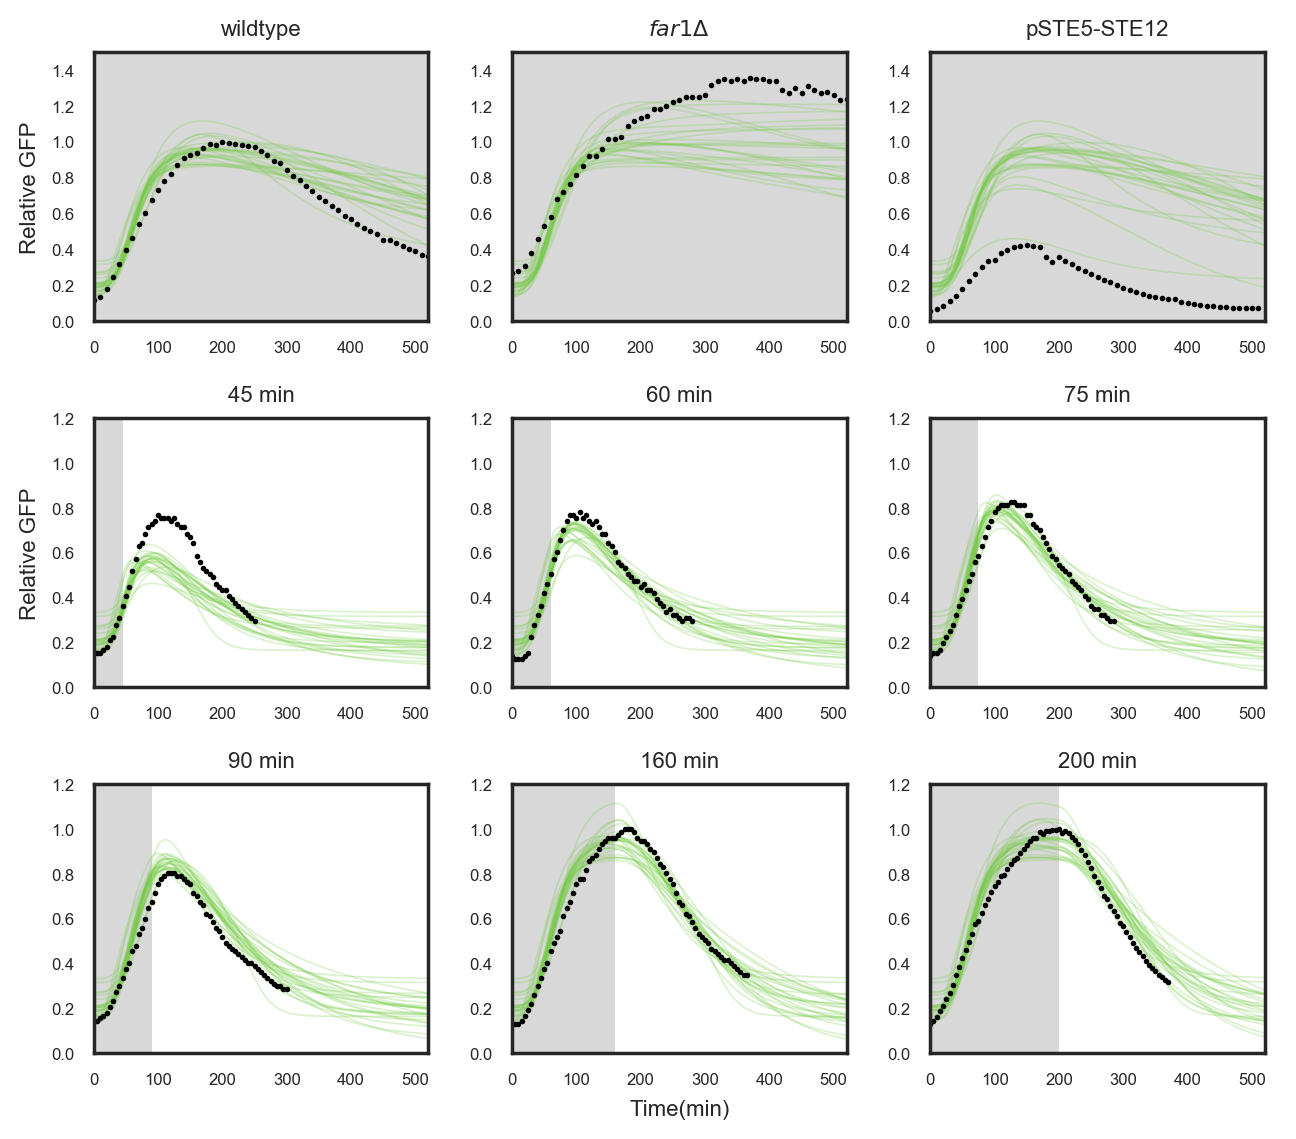

In [107]:
# Plot figure
# SPECIFY DATA SET
arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 

fig = plt.figure(figsize=(6.85039, 6))
gs = gridspec.GridSpec(3,3)
A = fig.add_subplot(gs[1,0])
B = fig.add_subplot(gs[1,1])
C = fig.add_subplot(gs[1,2])
D = fig.add_subplot(gs[2,0])
E = fig.add_subplot(gs[2,1])
F = fig.add_subplot(gs[2,2])
A1 = fig.add_subplot(gs[0,0])
B1 = fig.add_subplot(gs[0,1])
C1 = fig.add_subplot(gs[0,2])
ax = fig.add_subplot(gs[:,:])

# remove figure markings
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.grid('off')

#DEFINE STEADY STATE - WT
hc=2
kdegGFP=10**-1
time = np.linspace(0,570,571)
SS=[]
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    for i in [45,60,75,90,160,200]:
        expX = simulate_singlepulse_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 45:
            A.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 60: 
            B.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 75: 
            C.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 90:
            D.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 160:
            E.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 200:
            F.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
    for i in [1]:
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        A1.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
    kfb_org = kfb2 
    kfb2 = 0
    inds = [ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D]
    expX = simulate_periodic_experiment(inds, time, i,SS[j])
    C1.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
    kp4,ksynF1,ka5,kp3,kfb2 = [0,0,0,0,kfb_org]
    inds = [ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D]
    expX = simulate_periodic_experiment(inds, time, i,SS[j])
    B1.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)

scorefxn_time = times_50pulse
scorefxn_data = data_50pulse
A.plot(scorefxn_time[0], scorefxn_data[0], 'ko', markersize=2)
A.axis([0, 520, 0, 1.2])
B.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=2)
B.axis([0, 520, 0, 1.2])
C.plot(scorefxn_time[2], scorefxn_data[2], 'ko', markersize=2)
C.axis([0, 520, 0, 1.2])
D.plot(scorefxn_time[3], scorefxn_data[3], 'ko', markersize=2)
D.axis([0, 520, 0, 1.2])
E.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=2)
E.axis([0, 520, 0, 1.2])
F.plot(scorefxn_time[5], scorefxn_data[5], 'ko', markersize=2)
F.axis([0, 520, 0, 1.2])
A1.plot(times_50constant[0], data_50constant[0], 'ko', markersize=2)
A1.axis([0, 520, 0, 1.5])
B1.plot(times_50constant[2], data_50constant[2], 'ko', markersize=2)
B1.axis([0, 520, 0, 1.5])
C1.plot(times_50constant[1], data_50constant[1], 'ko', markersize=2)
C1.axis([0, 520, 0, 1.5])

for i in range(1):
    A.fill_between([i*90,i*90+45], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    B.fill_between([i*120,i*120+60], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    C.fill_between([i*150,i*150+75], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    D.fill_between([i*180,i*180+90], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    E.fill_between([i*320,i*320+160], 0, 1.2, facecolor='gray', alpha=0.3)
    
for i in range(1):
    F.fill_between([i*400,i*400+200], 0, 1.2, facecolor='gray', alpha=0.3)

A1.fill_between([0,570], 0, 1.5, facecolor='gray', alpha=0.3)
B1.fill_between([0,570], 0, 1.5, facecolor='gray', alpha=0.3)
C1.fill_between([0,570], 0, 1.5, facecolor='gray', alpha=0.3)
    
A.set_ylabel('Relative GFP')
ax.set_xlabel('Time(min)')
A1.set_ylabel('Relative GFP')

A.set_title('45 min')
B.set_title('60 min')
C.set_title('75 min')
D.set_title('90 min')
E.set_title('160 min')
F.set_title('200 min')
A1.set_title('wildtype')
B1.set_title('$far1\Delta$')
C1.set_title('pSTE5-STE12')
gs.tight_layout(fig)

plt.savefig('Figure S2.pdf',dpi=600)

# Figure 6

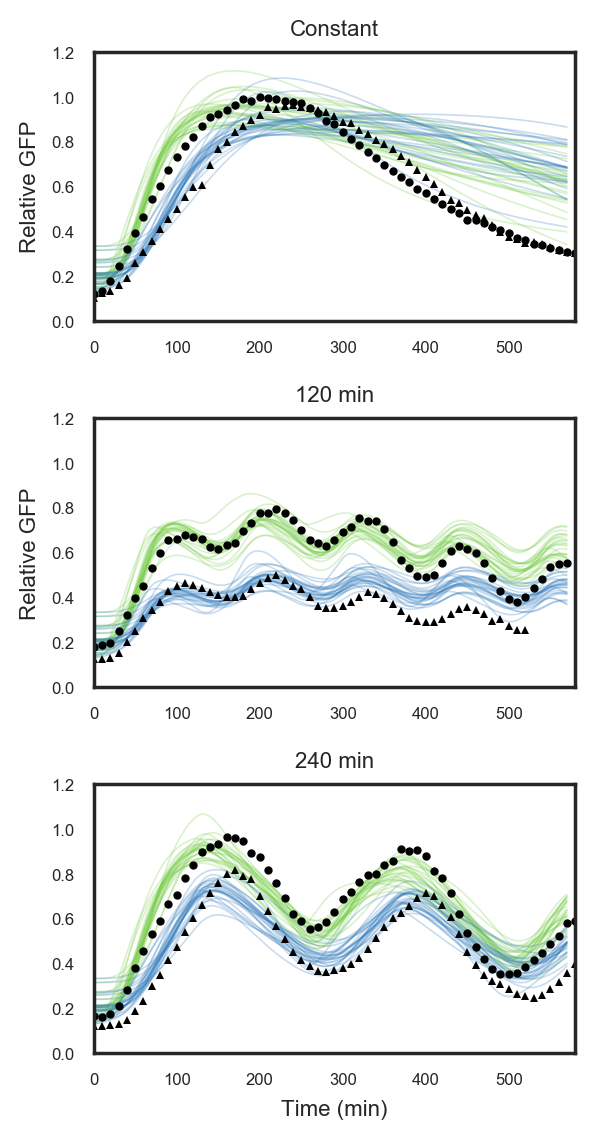

In [106]:
# plot
# SPECIFY DATA SET
arr_best_scores_P = all_best_scores_P
arr_end_scores_P = all_end_scores_P
arr_best_inds_P = all_best_inds_P
arrT_best_inds_P = allT_best_inds_P 

fig = plt.figure(figsize=(3.34646, 6))
gs = gridspec.GridSpec(3,1)
A = fig.add_subplot(gs[0,:])
B = fig.add_subplot(gs[1,:])
C = fig.add_subplot(gs[2,:])
ax = fig.add_subplot(gs[:,:])

# remove figure markings
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_facecolor('none')
ax.grid('off')

#50nM
hc=2
kdegGFP=10**-1
time = np.linspace(0,570,571)
SS=[]
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    for i in [120,240]:
        expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, i,SS[j])
        if i == 120:
            B.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
        elif i == 240: 
            C.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)
    expX = simulate_periodic_experiment(arr_best_inds_P[j][gen], time, 1,SS[j])
    A.plot(time, expX[:,0],color='xkcd:apple',alpha=0.25,linewidth=0.6)

#10nM
hc=2
kdegGFP=10**-1
time = np.linspace(0,570,571)
SS=[]
for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    slope_on = slope_on*0.3
    params = [ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D]
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    SS.append(odes[100000,:])

for j in range(len(arr_best_scores_P)):
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_best_inds_P[j][gen]
    slope_on = slope_on*0.3
    params = [ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D]
    for i in [120,240]:
        expX = simulate_periodic_experiment(params, time, i,SS[j])
        if i == 120:
            B.plot(time, expX[:,0],color='xkcd:bluish',alpha=0.25,linewidth=0.6)
        elif i == 240: 
            C.plot(time, expX[:,0],color='xkcd:bluish',alpha=0.25,linewidth=0.6)
    expX = simulate_periodic_experiment(params, time, 1,SS[j])
    A.plot(time, expX[:,0],color='xkcd:bluish',alpha=0.25,linewidth=0.6)

xmax = 580

scorefxn_time = times_10periodic
scorefxn_data = data_10periodic
B.plot(scorefxn_time[2], scorefxn_data[2], 'k^', markersize=3)
B.axis([0, xmax, 0, 1.2])
C.plot(scorefxn_time[5], scorefxn_data[5], 'k^', markersize=3)
C.axis([0, xmax, 0, 1.2])
A.plot(scorefxn_time[0], scorefxn_data[0], 'k^', markersize=3)
A.axis([0, xmax, 0, 1.2])

scorefxn_time = times_50periodic
scorefxn_data = data_50periodic
B.plot(scorefxn_time[1], scorefxn_data[1], 'ko', markersize=3)
B.axis([0, xmax, 0, 1.2])
C.plot(scorefxn_time[4], scorefxn_data[4], 'ko', markersize=3)
C.axis([0, xmax, 0, 1.2])

A.plot(times_50constant[0], data_50constant[0], 'ko', markersize=3)
A.axis([0, xmax, 0, 1.2])

A.set_ylabel('Relative GFP')
B.set_ylabel('Relative GFP')
ax.set_xlabel('Time (min)')

A.set_title('Constant')
B.set_title('120 min')
C.set_title('240 min')

fig.tight_layout()

plt.savefig('Figure 6.pdf',dpi=600)

# Cell cycle supplement

In [6]:
# Import Cell Cycle Data
cellcycle = pd.read_csv('~/Documents/ThesisWork/ModelSelection/Mating-Model/Data/Experimental Data/CellCycle.csv')
cellcycle_long = pd.wide_to_long(cellcycle, ["t="], i="id", j="timepoint")
cellcycle_long=cellcycle_long.reset_index()
cellcycle_long.head()
cellcycle_long.to_csv('yeastCellCycle.csv')

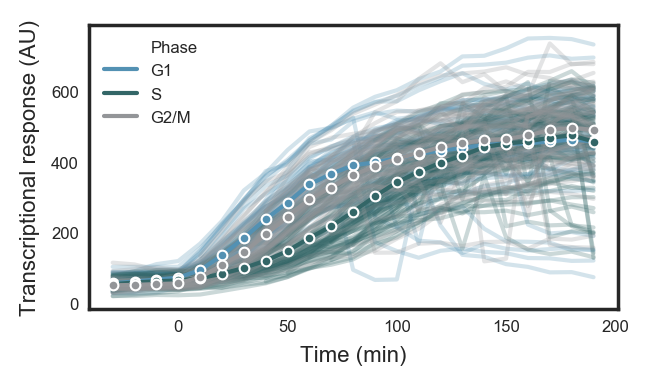

In [103]:
# plot
fig = plt.figure(figsize=(3.34646, 2))
gs = gridspec.GridSpec(1,1)
A = fig.add_subplot(gs[0,0])

sns.lineplot(data=cellcycle_long,
             x="timepoint", y='t=',hue="Phase",
             units="id", estimator=None, alpha = 0.25, ax = A)

sns.lineplot(data=cellcycle_long,markers=["o","o","o"],style="Phase",markersize = 3.5,dashes=False,
             x="timepoint", y='t=',hue="Phase", ax = A, err_style="bars", ci=0, legend = None)


A.set_xlabel('Time (min)')
A.set_ylabel('Transcriptional response (AU)')

fig.tight_layout()

plt.savefig('Cell Cycle Supplement Combined.pdf',dpi=600)

# Parameter ranges

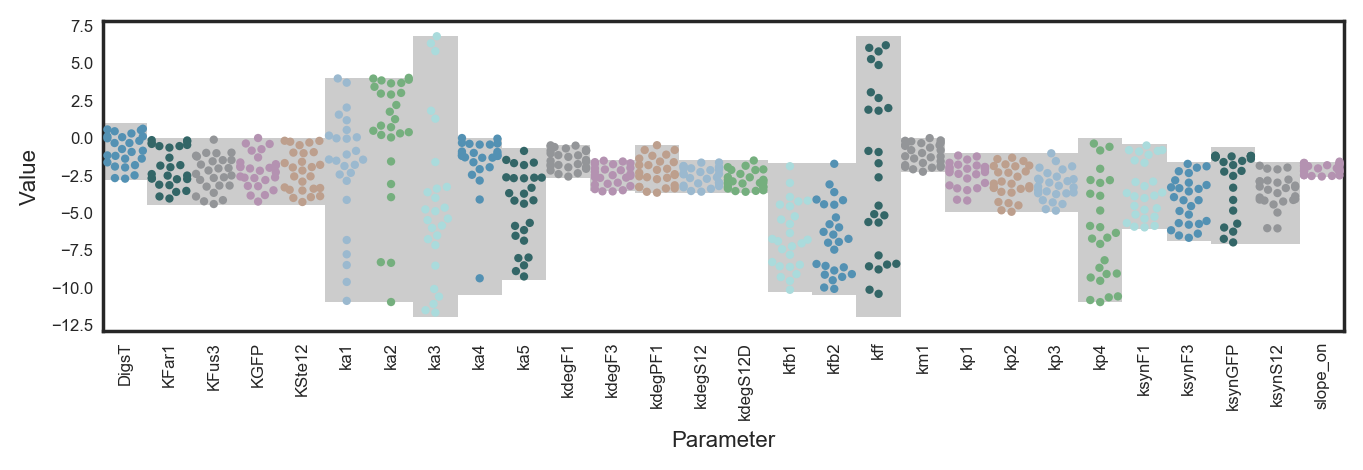

In [135]:
# Plot figure
fig = plt.figure(figsize=(6.85039, 3))
gs = gridspec.GridSpec(3,3)
ax3 = fig.add_subplot(gs[0:2,:])

for gen in [5]:
    
    d = []
    for i in range(len(arr_best_inds_P)):
        d.append({' ksynF3':np.log10(arr_best_inds_P[i][gen])[0],
                   ' kfb1':np.log10(arr_best_inds_P[i][gen])[1], 
                   ' KFus3':np.log10(arr_best_inds_P[i][gen])[2], 
                   ' kp1':np.log10(arr_best_inds_P[i][gen])[3],  
                   ' kp2':np.log10(arr_best_inds_P[i][gen])[4], 
                   ' kdegF3':np.log10(arr_best_inds_P[i][gen])[5], 
                   ' ksynS12':np.log10(arr_best_inds_P[i][gen])[6], 
                   ' kfb2':np.log10(arr_best_inds_P[i][gen])[7],  
                   ' KSte12':np.log10(arr_best_inds_P[i][gen])[8],
                   ' kdegS12':np.log10(arr_best_inds_P[i][gen])[9], 
                   ' kff1':np.log10(arr_best_inds_P[i][gen])[10], 
                   ' km1':np.log10(arr_best_inds_P[i][gen])[11], 
                   ' ka1':np.log10(arr_best_inds_P[i][gen])[12], 
                   ' DigsT':np.log10(arr_best_inds_P[i][gen])[13], 
                   ' ka2':np.log10(arr_best_inds_P[i][gen])[14], 
                   ' ka3':np.log10(arr_best_inds_P[i][gen])[15], 
                   ' ksynF1':np.log10(arr_best_inds_P[i][gen])[16], 
                   ' ka5':np.log10(arr_best_inds_P[i][gen])[17], 
                   ' KFar1':np.log10(arr_best_inds_P[i][gen])[18], 
                   ' kp3':np.log10(arr_best_inds_P[i][gen])[19], 
                   ' kp4':np.log10(arr_best_inds_P[i][gen])[20],
                   ' kdegF1':np.log10(arr_best_inds_P[i][gen])[21], 
                   ' kdegPF1':np.log10(arr_best_inds_P[i][gen])[22], 
                   ' ksynGFP':np.log10(arr_best_inds_P[i][gen])[23], 
                   ' ka4':np.log10(arr_best_inds_P[i][gen])[24],
                   ' KGFP':np.log10(arr_best_inds_P[i][gen])[25],
                   ' slope_on':np.log10(arr_best_inds_P[i][gen])[26],
                   ' kdegS12D':np.log10(arr_best_inds_P[i][gen])[27]})

    swarm_params = pd.DataFrame(d)
    
    unstacked = swarm_params.unstack().reset_index() 
    unstacked.columns = ['Parameter', 'index', 'Value']
    
labelnames = ['DigsT', 'KFar1', 'KFus3', 'KGFP', 'KSte12', 'ka1', 'ka2', 'ka3', 'ka4', 'ka5', 'kdegF1', 'kdegF3', 'kdegPF1', 'kdegS12','kdegS12D', 'kfb1', 'kfb2', 'kff', 'km1', 'kp1', 'kp2', 'kp3', 'kp4', 'ksynF1', 'ksynF3', 'ksynGFP', 'ksynS12','slope_on']
from pylab import *
g = sns.swarmplot(x="Parameter", y="Value", data=unstacked, ax=ax3, palette=fig3, size=3)
ax3.set_xticklabels(labelnames,rotation=90)
mins = [-2.8,-4.5,-4.5,-4.5,-4.5,-11,-11,-12,-10.5,-9.5,-2.7,-3.6,-3.7,-3.7,-3.7,-10.3,-10.5,-12,-2.3,-5,-5,-5,-11,-6.1,-6.9,-7.1,-7.1,-2.6]
maxes = [1,0,0,0,0,4,4,6.8,0.0,-0.7,-0.5,-1.5,-0.5,-1.5,-1.5,-1.7,-1.7,6.8,0,-1,-1,-1,0,-0.4,-1.6,-0.6,-1.6,-1.6]
for i in range(len(mins)):
    ax3.fill([i-0.5,i+0.5,i+0.5,i-0.5], [mins[i],mins[i],maxes[i],maxes[i]], 'k', alpha=0.2)

ax.set_ylabel('Transcriptional response')
ax.set_xlabel('Time (minutes)')

A.set_title('90 minutes')
B.set_title('120 minutes')
C.set_title('150 minutes')
D.set_title('180 minutes')
E.set_title('240 minutes')
F.set_title('320 minutes')

gs.tight_layout(fig)

plt.savefig('Parameter Ranges.pdf',dpi=600)

In [134]:
# WT Constant error calculator
def constant_scorefxn(arr_parameters):
    time = np.linspace(0,600,6001)
    # Solve steady state
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_parameters
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    TE=0
    for i in range(len(IC)):
        TE+=abs(odes[100000,i]-odes[100000-1,i])
    #print TE
    SS = odes[100000,:]
    
    expX = simulate_periodic_experiment(arr_parameters, time, 1,SS)
        
    # get index of time points closest
    
    idx_closest_time_points = []
    for each_time in times_50constant[0][~np.isnan(times_50constant[0])]:
        closest_idx = min(range(len(time)),key = lambda i: abs(time[i] - each_time))
        idx_closest_time_points.append(closest_idx)
        
    # use indexes of time points to get data points to score against
    expX_scorefxn_data = expX[[idx_closest_time_points]]
        
    #SCORE IT! using MSE
    expX_mse = (np.abs(data_50constant[0][~np.isnan(data_50constant[0])] - expX_scorefxn_data[:,0])).mean()
    return expX_mse

# far1D constant error calculator
def far1D_scorefxn(arr_parameters):
    time = np.linspace(0,600,6001)
    
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_parameters
    kp4,ksynF1,ka5,kp3 = [0,0,0,0]
    
    mut_params = [ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D]
    
    # Solve steady state
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    TE=0
    for i in range(len(IC)):
        TE+=abs(odes[100000,i]-odes[100000-1,i])
    #print TE
    SS = odes[100000,:]
    
    expX = simulate_periodic_experiment(mut_params, time, 1,SS)
        
    # get index of time points closest
    
    idx_closest_time_points = []
    for each_time in times_50constant[2][~np.isnan(times_50constant[2])]:
        closest_idx = min(range(len(time)),key = lambda i: abs(time[i] - each_time))
        idx_closest_time_points.append(closest_idx)
        
    # use indexes of time points to get data points to score against
    expX_scorefxn_data = expX[[idx_closest_time_points]]
        
    #SCORE IT! using MSE
    expX_mse = (np.abs(data_50constant[2][~np.isnan(data_50constant[2])] - expX_scorefxn_data[:,0])).mean()
    return expX_mse

# Single pulse error calculator
def pulse_scorefxn(arr_parameters):
    expX_mse = 0
    time = np.linspace(0,600,6001)
    
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_parameters
    
    # Solve steady state
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    TE=0
    for i in range(len(IC)):
        TE+=abs(odes[100000,i]-odes[100000-1,i])
    #print TE
    SS = odes[100000,:]
    for n,i in enumerate([45,60,75,90,160,200]):
        expX = simulate_singlepulse_experiment(arr_parameters, time, i,SS)

        # get index of time points closest

        idx_closest_time_points = []
        for each_time in times_50pulse[n][~np.isnan(times_50pulse[n])]:
            closest_idx = min(range(len(time)),key = lambda i: abs(time[i] - each_time))
            idx_closest_time_points.append(closest_idx)

        # use indexes of time points to get data points to score against
        expX_scorefxn_data = expX[[idx_closest_time_points]]

        #SCORE IT! using MSE
        expX_mse += (np.abs(data_50pulse[n][~np.isnan(data_50pulse[n])] - expX_scorefxn_data[:,0])).mean()
        return expX_mse

# Periodic error calculator
def periodic_scorefxn(arr_parameters):
    expX_mse = 0
    time = np.linspace(0,600,6001)
    
    ksynF3,kfb1,KFus3,kp1,kp2,kdegF3,ksynS12,kfb2,KSte12,kdegS12,kff,km1,ka1,DigsT,ka2,ka3,ksynF1,ka5,KFar1,kp3,kp4,kdegF1,kdegPF1,ksynGFP,ka4,KGFP,slope_on,kdegS12D = arr_parameters
    
    # Solve steady state
    IC = [0,0,0,0,0,0,0]
    t  = np.linspace(0,40000,100001)
    odes = odeint(DE_periodic, IC, t, args=(0,100,100,))
    TE=0
    for i in range(len(IC)):
        TE+=abs(odes[100000,i]-odes[100000-1,i])
    #print TE
    SS = odes[100000,:]
    for n,i in enumerate([90,120,150,180,240,320]):
        expX = simulate_periodic_experiment(arr_parameters, time, i,SS)

        # get index of time points closest

        idx_closest_time_points = []
        for each_time in times_50periodic[n][~np.isnan(times_50periodic[n])]:
            closest_idx = min(range(len(time)),key = lambda i: abs(time[i] - each_time))
            idx_closest_time_points.append(closest_idx)

        # use indexes of time points to get data points to score against
        expX_scorefxn_data = expX[[idx_closest_time_points]]

        #SCORE IT! using MSE
        expX_mse += (np.abs(data_50periodic[n][~np.isnan(data_50periodic[n])] - expX_scorefxn_data[:,0])).mean()
        return expX_mse

In [136]:
# Constant
inds = [wt_best_inds_P, cons_best_inds_P, noPer_best_inds_P, noPul_best_inds_P, all_best_inds_P]
constant_err = []
for j in range(5):
    arr_best_inds_P = inds[j]
    err_all = []
    for i in range(len(arr_best_inds_P)):
        err_all.append(constant_scorefxn(arr_best_inds_P[i][100]))
    constant_err.append(np.mean(err_all))
print(constant_err)

#Far1D
inds = [wt_best_inds_P, cons_best_inds_P, noPer_best_inds_P, noPul_best_inds_P, all_best_inds_P]
far1_err = []
for j in range(5):
    arr_best_inds_P = inds[j]
    err_all = []
    for i in range(len(arr_best_inds_P)):
        err_all.append(far1D_scorefxn(arr_best_inds_P[i][100]))
    far1_err.append(np.mean(err_all))
print(far1_err)

#Pulses
inds = [wt_best_inds_P, cons_best_inds_P, noPer_best_inds_P, noPul_best_inds_P, all_best_inds_P]
pulse_err = []
for j in range(5):
    arr_best_inds_P = inds[j]
    err_all = []
    for i in range(len(arr_best_inds_P)):
        err_all.append(pulse_scorefxn(arr_best_inds_P[i][100]))
    pulse_err.append(np.mean(err_all))
print(pulse_err)

#Periodic
inds = [wt_best_inds_P, cons_best_inds_P, noPer_best_inds_P, noPul_best_inds_P, all_best_inds_P]
periodic_err = []
for j in range(5):
    arr_best_inds_P = inds[j]
    err_all = []
    for i in range(len(arr_best_inds_P)):
        err_all.append(periodic_scorefxn(arr_best_inds_P[i][100]))
    periodic_err.append(np.mean(err_all))
print(periodic_err)

[0.21191085154067937, 0.2082625094119499, 0.21774675108563257, 0.21513866271362306, 0.21534428151013976]
[0.30213660993705599, 0.29627816867511048, 0.31192582341760605, 0.30775965333188932, 0.30765048370720388]
[0.11217829140439385, 0.10924039385914659, 0.12728734644893056, 0.12489654768354086, 0.11304503183670361]
[0.12788541355272415, 0.12031144286302932, 0.14657077118916781, 0.14079082548752522, 0.13443413935383131]


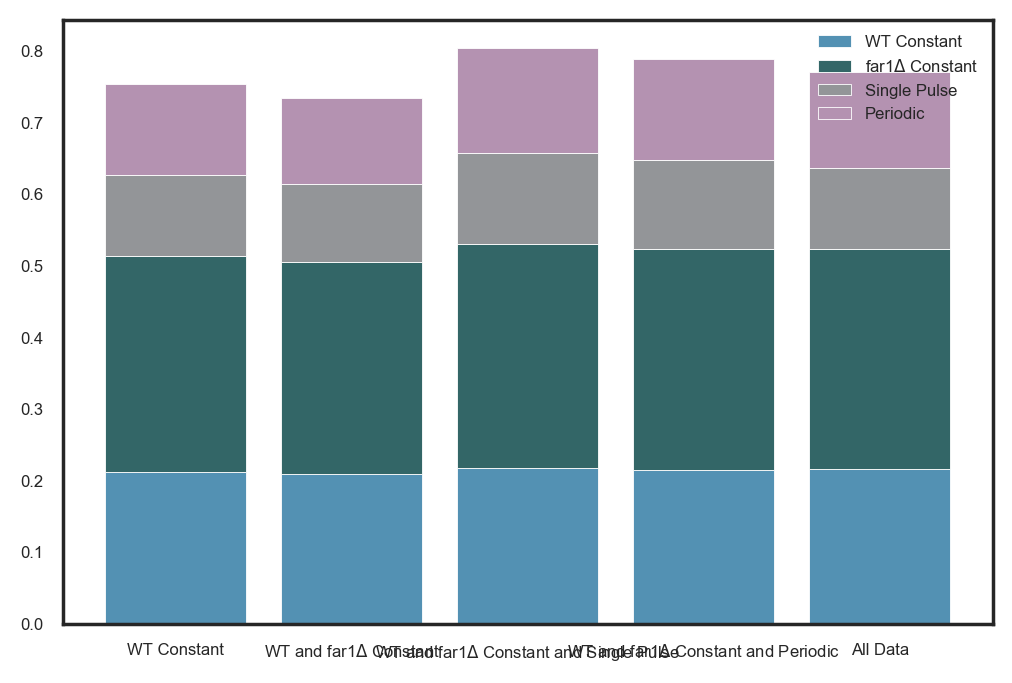

In [138]:
fitsets = ['WT Constant', 'WT and far1$\Delta$ Constant', 'WT and far1$\Delta$ Constant and Single Pulse', 'WT and far1$\Delta$ Constant and Periodic', 'All Data']
dataset = ['WT Constant', 'far1$\Delta$ Constant', 'Single Pulse', 'Periodic']
 
# Values of each group
bars1 = constant_err
bars2 = far1_err
bars3 = pulse_err
bars4 = periodic_err
 
# Heights of bars1 + bars2
bars = np.add(bars1, bars2).tolist()
bars_all = np.add(bars, bars3).tolist()
 
# The position of the bars on the x-axis
r = [0,1,2,3,4]
 
# Names of group and bar width
names = fitsets
barWidth = 0.8
 
# Create brown bars
plt.bar(r, bars1, edgecolor='white', width=barWidth)
# Create green bars (middle), on top of the firs ones
plt.bar(r, bars2, bottom=bars1, edgecolor='white', width=barWidth)
# Create green bars (top)
plt.bar(r, bars3, bottom=bars, edgecolor='white', width=barWidth)
# Create green bars (top)
plt.bar(r, bars4, bottom=bars_all, edgecolor='white', width=barWidth)
 
# Custom X axis
plt.xticks(r, names)

plt.legend(dataset)
 
# Show graphic
plt.show()